In [29]:
from pathlib import Path  # pathlib: module, Path: class. Checking if a path exist
from typing import Optional, List, Dict, Tuple  # typing: support for type hint
import pandas as pd
import numpy as np
import collections  # This module contains different datatype to process the data: dict, list, set, and tuple.
from pprint import pprint  # pprint.pprint() can use when you need to examine the structure of a large or complex
# data structure. this output reveals more readable and structured way.
from who_member_states import WHO_MEMBER_STATES

__all__ = ['select_df']  # only import 'select_df'


# test data should <10 MB

def select_df(df: pd.DataFrame,
              rename_mapping: Dict[str, str] = None,
              column_drop: Optional[List[str]] = None,  # column_drop (param) is an optional list of string. Optional
              # type is from Typing. default is None (no drop any column). If provide column_drop, must be ['xxx'] (
              # list of string)
              year: int = 2000,
              save_path: Optional[Path] = None,
              drop_na: Optional[List[str]] = None, ) -> pd.DataFrame:
    """
    dataframe modification and save as another file

    :param df: input dataframe
    :param rename_mapping: both df have countries but the header is different
    :param column_drop: drop the column(s) that are not informative
    :param year: pick up the data that larger than which year
    :param save_path: path for saving the modified dataframe
    :param drop_na: specify if drop the na-existing column name
    :return: modified df
    """

    df = df.copy()  # The copy() method returns a copy of the DataFrame. By default, the copy is a "deep copy"
    # meaning that any changes  made in the original DataFrame will NOT be reflected in the copy. 新跑出來的df不會影響最原始的df

    if rename_mapping is not None:
        df = df.rename(columns=rename_mapping)
    if column_drop is not None:  # if drop specific column,df need to drop the option
        df = df.drop(columns=column_drop)  # df 的column = column after drop, column_drop: Optional[List[str]]

    year_mask: pd.Series[bool] = df['Year'] >= year  # type is list of bool; compared df["year"] whether larger than
    # default year (year: int = 2000)
    entity_mask: List[bool] = [country in WHO_MEMBER_STATES for country in df['Entity']]  # check countries whether
    # in df['Entity'] also in WHO_MEMBER_STATES. If Yes =True
    modified_df: pd.DataFrame = df[year_mask & entity_mask].reset_index(
        drop=True)  # create a new df that only meet both
    # year_mask and entity_mask. df.reset_index(drop = True) means new index created, old index don't added in new df.

    if drop_na is not None:  # drop rows with missing values ('NaN') from df
        try:
            modified_df.dropna(subset=drop_na, inplace=True)
            # inplace = True means that the original df will be modified and no copy will be made.; But, if inplace = False,
        # df will still show the initial one. subset = drop_na means drop in specific place you set.
        except KeyError as e:
            raise ValueError(f'{e} not in the dataframe, should be one of the {modified_df.columns.tolist()}')  # If
            # typed wrong, show the list which should be dropped.
    if save_path is not None:
        modified_df.to_csv(Path)

    return modified_df



In [30]:
raw_who_cvd_df = pd.read_csv(
        '/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/raw '
        'data/WHO_Cardiovascular_Disease_Mortality_Database.csv')
number_of_countries=raw_who_cvd_df['Country Name'].unique()
print(len(number_of_countries),raw_who_cvd_df.shape, raw_who_cvd_df.columns.tolist())

114 (297066, 13) ['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age group code', 'Age Group', 'Number', 'Percentage of cause-specific deaths out of total deaths', 'Age-standardized death rate per 100 000 standard population', 'Death rate per 100 000 population', 'Unnamed: 12']


In [31]:
rename = {'Country Name': 'Entity'}
column_drop = ['Age group code', 'Country Code', 'Region Name', 'Region Code',
                   'Age-standardized death rate per 100 000 standard population', 'Unnamed: 12']
na_header = ['Number',
                 'Percentage of cause-specific deaths out of total deaths',
                 'Death rate per 100 000 population']
who_cvd_df = select_df(raw_who_cvd_df, rename_mapping=rename, column_drop=column_drop, drop_na=na_header)
print(len(who_cvd_df['Entity'].unique()),who_cvd_df.shape,who_cvd_df.columns.tolist())

98 (98949, 7) ['Entity', 'Year', 'Sex', 'Age Group', 'Number', 'Percentage of cause-specific deaths out of total deaths', 'Death rate per 100 000 population']


In [32]:
raw_tobacco_df = pd.read_csv(
        "/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/raw "
        "data/Prevalence_of_current_tobacco_use_between_Males_and_Females.csv")
number_of_countries=raw_tobacco_df['Entity'].unique()
print(len(number_of_countries),raw_tobacco_df.shape,raw_tobacco_df.columns.tolist())

310 (57051, 7) ['Entity', 'Code', 'Year', 'Prevalence of current tobacco use, males (% of male adults)', 'Prevalence of current tobacco use, females (% of female adults)', 'Population (historical estimates)', 'Continent']


In [33]:
column_drop = ['Code', 'Continent']
na_header = ['Prevalence of current tobacco use, males (% of male adults)',
                 'Prevalence of current tobacco use, females (% of female adults)']

tobacco_df = select_df(raw_tobacco_df, column_drop=column_drop, drop_na=na_header)
print(len(tobacco_df['Entity'].unique()),tobacco_df.shape,tobacco_df.columns.tolist())

159 (1113, 5) ['Entity', 'Year', 'Prevalence of current tobacco use, males (% of male adults)', 'Prevalence of current tobacco use, females (% of female adults)', 'Population (historical estimates)']


In [34]:
rename = {'Prevalence of current tobacco use, males (% of male adults)':'Prevalence of Current Tobacco Use in Males (%)'
         ,'Prevalence of current tobacco use, females (% of female adults)':'Prevalence of Current Tobacco Use in Females (%)'}
tobacco_df = select_df(tobacco_df,rename_mapping= rename)



print(len(tobacco_df['Entity'].unique()),tobacco_df.shape,tobacco_df.columns.tolist())


159 (1113, 5) ['Entity', 'Year', 'Prevalence of Current Tobacco Use in Males (%)', 'Prevalence of Current Tobacco Use in Females (%)', 'Population (historical estimates)']


In [35]:
def preprocess_cvd(df: pd.DataFrame,
                   drop_na: Optional[List[str]] = None,
                   save_path: Optional[Path] = None) -> pd.DataFrame:
    """
    Dataframe of WHO_CVD_Mortality_Age over 15_Year over 2000.xlsx need to modify:
    - grouping if set kwarg `grouping_age` as true  # kwarg : keyword arguments
    - Calculate Total number of death
    - save as another dataframe

    :param df: input dataframe (WHO_CVD_Mortality_Age over 15_Year over 2000.xlsx)
    :param drop_na: drop Age_Group <15 year-old
    :param save_path: save modified dataframe to another excel
    :return: df
    """

    # Sum of number of death in each age group
    numbers = df['Number']
    percentage = df['Percentage of cause-specific deaths out of total deaths']
    df["Total number of death"] = numbers * 100 / percentage
    total_number_of_death = df["Total number of death"]
    mask_nan = np.isnan(total_number_of_death)  # type: pd.Series[bool] # if value is NaN, NaN = True

    df.loc[mask_nan, 'Total number of death'] = 0  # search location of df. if index ('Total number of death') is
    # NaN, change NaN to 0. ( if no.loc :SettingWithCopyWarning: A value is trying to be set on a copy of a slice
    # from a DataFrame
    df['Total number of death'] = df['Total number of death'].astype(int)  # astype can cast/change multiple types (
    # change type to int)
    if drop_na is not None:  # drop rows with missing values ('NaN') from df
        df = df.mask(df['Age Group'].isin(['[0]', '[1-4]', '[5-9]', '[10-14]']), np.nan)
        df.dropna(subset=['Age Group'], inplace=True)

    if save_path is not None:
        df.to_excel(Path)
    return df

who_cvd_df = pd.read_excel(
    '/Users/wei/Python/MPHDissertation/test_file/WHO_CVD_Mortality_Age over 15_Year over 2000.xlsx', engine='openpyxl')
# “xlrd” supports old-style Excel files (.xls).“openpyxl” supports newer Excel file formats.

who_cvd_df = preprocess_cvd(who_cvd_df)  # assign a who_cvd_df after preprocess_cvd

print(len(who_cvd_df['Entity'].unique()),who_cvd_df.shape)

98 (79239, 9)


In [36]:
def create_age_grouping(df: pd.DataFrame,
                        save: Optional[Path] = None) -> pd.DataFrame:
    """
    Calculate: Total percentage of CVD of total deaths = Sum of number/ Sum of Total number of
    death * 100 (Male/ Female/ All in each year and country)
    grouping_age: Age groups --> one age group (greater 15 y/o)
    create a new df and save it to excel

    :param df: df after select_df and preprocess_cvd
    :param save: save modified dataframe to another excel
    :return: new df
    """

    if 'Total number of death' not in df.columns:
        raise RuntimeError('call preprocess_cvd in advance')

    dy: dict = collections.defaultdict(list)  # defaultdict object in collections. datatype will be dict. Using list
    # as the default_factory to group a sequence of key-value pairs into a dictionary of lists
    group = df.groupby(['Entity', 'Year', 'Sex'])
    info: List[Tuple] = list(group.groups.keys())  # List[Tuple]: value is a list of tuple[()].looking for the keys in a
    # dict. The 'groups' attribute of the 'groupby' object is always dic type

    for i, it in enumerate(info):  # i = index ( starting from 0) , it = item (Entity, Year, Sex). enumerate can pair
        # index and item
        dy['Entity'].append(it[0])  # Entity in [0]
        dy['Year'].append(it[1])  # Year in [1]
        dy['Sex'].append(it[2])  # Sex in [2]

    numbers = group['Number']
    total_number_of_death = group['Total number of death']
    # noinspection PyTypeChecker todo: wt is it?
    dy['Number'] = np.array(numbers.sum())
    dy['Total number of death'] = np.array(total_number_of_death.sum())
    dy['Total percentage of CVD'] = np.array(numbers.sum() / total_number_of_death.sum() * 100)

    _df = pd.DataFrame.from_dict(dy)  # creates a new_df from the dy dictionary.

    # change layout
    sex_values = ['All', 'Female', 'Male']
    new_df = _df.assign(
        All_number=_df.query("Sex == 'All'")['Number'],
        Female_number=_df.query("Sex == 'Female'")['Number'],
        Male_number=_df.query("Sex == 'Male'")['Number'],
        All_total_number_of_death=_df.query("Sex == 'All'")['Total number of death'],
        Female_total_number_of_death=_df.query("Sex == 'Female'")['Total number of death'],
        Male_total_number_of_death=_df.query("Sex == 'Male'")['Total number of death'],
        All_total_percentage_of_CVD=_df.query("Sex == 'All'")['Total percentage of CVD'],
        Female_total_percentage_of_CVD=_df.query("Sex == 'Female'")['Total percentage of CVD'],
        Male_total_percentage_of_CVD=_df.query("Sex == 'Male'")['Total percentage of CVD'])
    new_df.reset_index(drop=True, inplace=True)

    new_df = new_df.drop(['Sex', 'Number', 'Total number of death', 'Total percentage of CVD'],
                         axis=1)  # axis = 1: specifies to drop columns

    new_df = new_df.groupby(['Entity', 'Year']).first().reset_index()  # The first method is then applied to
    # the grouped dataframe, which returns the first row of each group
    if save:
        new_df.to_excel(Path)
    return new_df

new_df = create_age_grouping(who_cvd_df)
print(len(new_df['Entity'].unique()),new_df.shape)

98 (1670, 11)


In [37]:
# merge df1 & df2 test
df1 = new_df
df2 = tobacco_df

cvd_tobacco = pd.merge(df1, df2, on=['Entity', 'Year'], how='outer')
cvd_tobacco.fillna(value='NaN', inplace=True)
print(len(cvd_tobacco['Entity'].unique()),cvd_tobacco.shape)


171 (2345, 14)


In [38]:
#drop_missing_data
df = pd.read_excel('/Users/wei/Python/MPHDissertation/test_file/CVD_Tobacco_merged_with_missingdata.xlsx')
df = df.dropna(how='any')  # drop the rows having Nan
# df.to_excel('no_missing_data.xlsx')
countries = df['Entity'].unique()
number_of_countries = len(countries)
print(number_of_countries, countries, df.shape)  # 85 countries


85 ['Albania' 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Canada' 'Chile' 'Colombia'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Fiji'
 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Guatemala' 'Guyana'
 'Hungary' 'Iceland' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kuwait' 'Kyrgyzstan' 'Latvia' 'Lebanon'
 'Lithuania' 'Luxembourg' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Montenegro' 'Netherlands' 'New Zealand' 'Norway' 'Panama' 'Paraguay'
 'Peru' 'Philippines' 'Poland' 'Portugal' 'Romania' 'Serbia' 'Seychelles'
 'Singapore' 'Slovakia' 'Slovenia' 'South Africa' 'Spain' 'Sri Lanka'
 'Sweden' 'Switzerland' 'Thailand' 'Turkey' 'Turkmenistan' 'Ukraine'
 'United Kingdom' 'Uruguay' 'Uzbekistan'] (438, 14)


In [39]:
def format_date(df: pd.DataFrame,
                rename_mapping: Dict[str, str] = None,
                uniform_date: Optional[List[str]] = None,
                save_path: Optional[Path] = None) -> pd.DataFrame:
    if rename_mapping is not None:
        df = df.rename(columns=rename_mapping)
    if uniform_date is not None:
        for col in uniform_date:
            df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
            df[col] = df[col].dt.strftime('%d/%m/%Y')
    df.fillna(value='Nan', inplace=True)
    if save_path is not None:
        df.to_excel(save_path)
    return df

In [40]:
df = pd.read_excel('/Users/wei/Python/MPHDissertation/test_file/WHO_FCTC_Parties_date_filter .xlsx')
rename = {"Ratification, Acceptance(A), Approval(AA), Formal confirmation(c), Accession(a), Succession(d)": 'Ratification'}
uniform_date = ['Signature', 'Ratification']
# save_path = '/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/WHOFCTC_Parties_date_filter.xlsx'
format_date(df, rename_mapping=rename, uniform_date=uniform_date)

,Participant,Signature,Ratification
0,Albania,29/06/2004,26/04/2006
1,Argentina,25/09/2003,Nan
2,Armenia,Nan,29/11/2004
3,Australia,05/12/2003,27/10/2004
4,Austria,28/08/2003,15/09/2005
...,...,...,...
80,Turkmenistan,Nan,13/05/2011
81,Ukraine,25/06/2004,06/06/2006
82,United Kingdom of Great Britain and Northern I...,16/06/2003,16/12/2004
83,Uruguay,19/06/2003,09/09/2004


In [41]:
def ratified_parties(df: pd.DataFrame,
                     drop_na: None,
                     save_path: Optional[Path] = None) -> pd.DataFrame:
    if drop_na is not None:
        df = df.mask(df['Entity'].isin(['Argentina', 'Cuba', 'Switzerland']), np.nan)
        df.dropna(subset=['Entity'], inplace=True)
        df = df.dropna(how='any')
        
    if save_path is not None:
        df.to_excel(save_path)
    return df

In [42]:
df1 = pd.read_excel('/Users/wei/Python/MPHDissertation/test_file/CVD_Tobacco_merged_without_missingdata.xlsx')
drop_na = True
save_path = '/Users/wei/Python/MPHDissertation/src/test_ratifies.xlsx'
ratified_parties(df1, drop_na=drop_na, save_path=save_path)

,Unnamed: 0,Entity,Year,All_number,Female_number,Male_number,All_total_number_of_death,Female_total_number_of_death,Male_total_number_of_death,All_total_percentage_of_CVD,Female_total_percentage_of_CVD,Male_total_percentage_of_CVD,"Prevalence of current tobacco use, males (% of male adults)","Prevalence of current tobacco use, females (% of female adults)",Population (historical estimates)
0,0.0,Albania,2000.0,15175.0,7018.0,8157.0,30817.0,13030.0,17783.0,49.242301,53.860322,45.869651,59.000000,10.9,3182027.0
5,5.0,Albania,2005.0,17498.0,8340.0,9158.0,34089.0,15125.0,18956.0,51.330341,55.140496,48.311880,53.200001,9.4,3032636.0
10,10.0,Albania,2010.0,13258.0,6594.0,6664.0,23942.0,11018.0,12917.0,55.375491,59.847522,51.590927,47.900002,8.1,2913402.0
47,47.0,Armenia,2000.0,26390.0,13875.0,12515.0,47230.0,23183.0,24042.0,55.875503,59.849890,52.054738,61.700001,2.2,3168525.0
55,55.0,Armenia,2010.0,27309.0,14040.0,13269.0,55144.0,26385.0,28751.0,49.523067,53.212052,46.151438,55.400002,1.8,2946296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,1658.0,Uzbekistan,2005.0,158148.0,79714.0,78434.0,267984.0,126384.0,141601.0,59.013971,63.072857,55.390852,44.099998,1.3,26573428.0
1660,1660.0,Uzbekistan,2010.0,169002.0,83279.0,85723.0,265589.0,124019.0,141564.0,63.632906,67.150195,60.554237,40.500000,1.3,28614234.0
1665,1665.0,Uzbekistan,2015.0,179524.0,85267.0,94257.0,291193.0,132671.0,158517.0,61.651207,64.269509,59.461761,37.000000,1.2,30949416.0
1668,1668.0,Uzbekistan,2018.0,186629.0,87755.0,98874.0,297950.0,135678.0,162265.0,62.637691,64.678872,60.933658,35.299999,1.1,32449578.0


In [43]:

import matplotlib.pyplot as plt

WHOFCTC_Parties_date = pd.read_excel("/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/WHOFCTC_Parties_date_filter.xlsx")
CVD_Tobacco_ratified_parites = pd.read_excel("/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/CVD_Tobacco_Parties_ratified.xlsx")
WHOFCTC_Parties_date = WHOFCTC_Parties_date[WHOFCTC_Parties_date['Ratification'] != 'Nan']
WHOFCTC_Parties_date['Ratification'] = pd.to_datetime(WHOFCTC_Parties_date['Ratification'], infer_datetime_format='%d/%m/%Y')
WHOFCTC_Parties_date['Year'] = WHOFCTC_Parties_date['Ratification'].dt.year
WHOFCTC_Parties_date

,Unnamed: 0,Participant,Signature,Ratification,Year
0,0,Albania,29/06/2004,2006-04-26,2006
2,2,Armenia,Nan,2004-11-29,2004
3,3,Australia,05/12/2003,2004-10-27,2004
4,4,Austria,28/08/2003,2005-09-15,2005
5,5,Azerbaijan,Nan,2005-11-01,2005
...,...,...,...,...,...
80,80,Turkmenistan,Nan,2011-05-13,2011
81,81,Ukraine,25/06/2004,2006-06-06,2006
82,82,United Kingdom of Great Britain and Northern I...,16/06/2003,2004-12-16,2004
83,83,Uruguay,19/06/2003,2004-09-09,2004


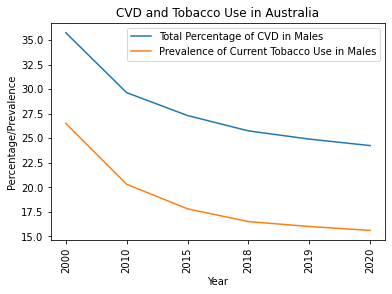

In [45]:
CVD_Tobacco_ratified_parites = CVD_Tobacco_ratified_parites[CVD_Tobacco_ratified_parites['Entity'] == 'Australia']
years = CVD_Tobacco_ratified_parites['Year'].astype(str)
plt.plot(years, CVD_Tobacco_ratified_parites['Male_total_percentage_of_CVD'], label='Total Percentage of CVD in Males')
plt.plot(years, CVD_Tobacco_ratified_parites['Prevalence of current tobacco use, males (% of male adults)'], label='Prevalence of Current Tobacco Use in Males')
plt.xlabel('Year')
plt.ylabel('Percentage/Prevalence')
plt.legend()
plt.xticks(years, rotation=90)
plt.title('CVD and Tobacco Use in Australia')
plt.show()


In [56]:

def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: str = None,
                      y_label: str = None,
                      save_path: Optional[Path] = None) -> pd.DataFrame:
    df['Year'] = df['Year'].astype(str)
    if select_country is not None:
        for country in select_country:
            df = df[df['Entity'] == country]
        #df = df[df['Entity'].isin(select_country)]
            if variable_1 is not None:
                plt.plot(df['Year'], df[variable_1[0]], label=variable_1[0])
            if variable_2 is not None:
                plt.plot(df['Year'], df[variable_2[0]], label=variable_2[0])
            if x_label is not None:
                plt.xlabel(x_label)
            if y_label is not None:
                plt.ylabel(y_label)
            plt.legend()
            plt.xticks(df['Year'], rotation=90)

            plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {select_country[0]}')
            plt.show()

    if save_path is not None:
        df.to_excel(save_path)
    return df



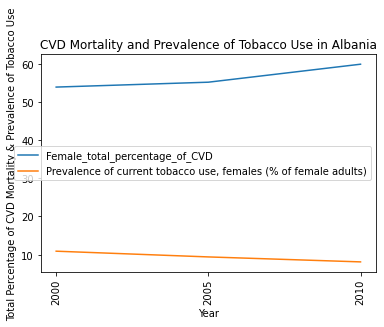

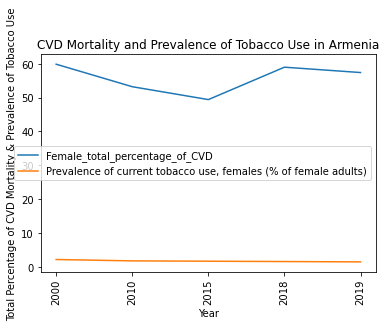

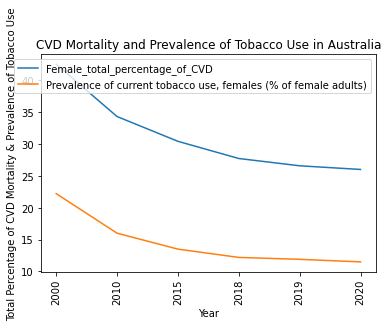

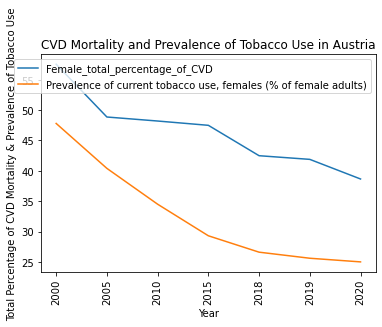

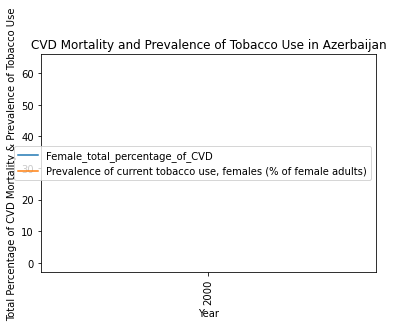

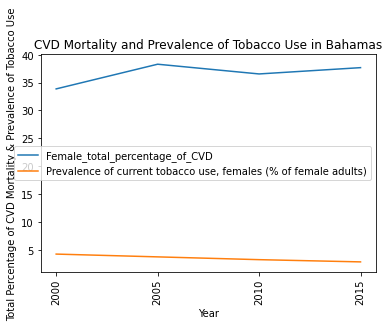

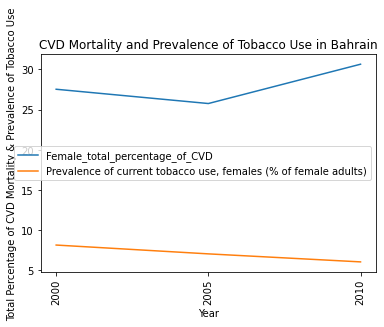

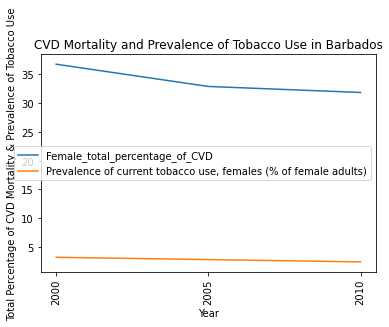

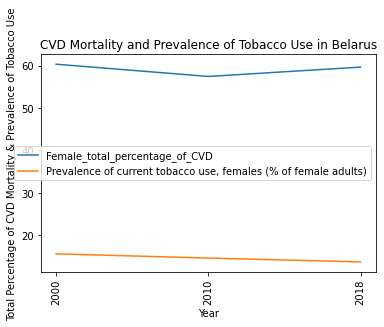

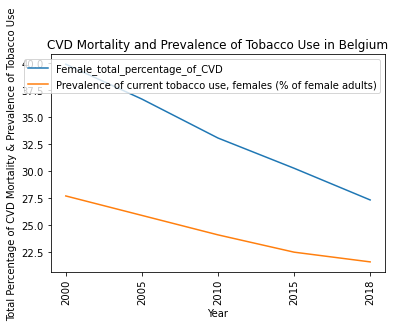

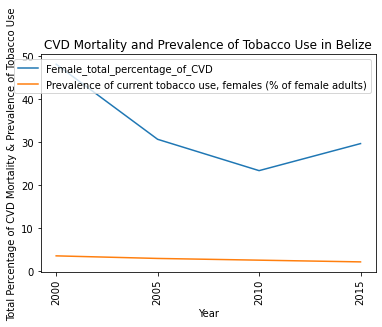

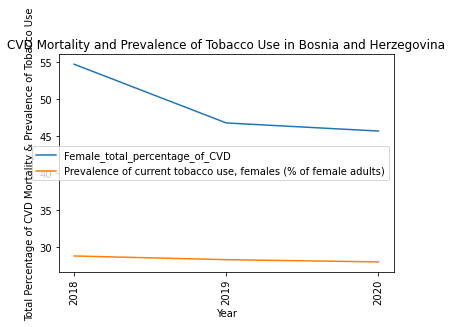

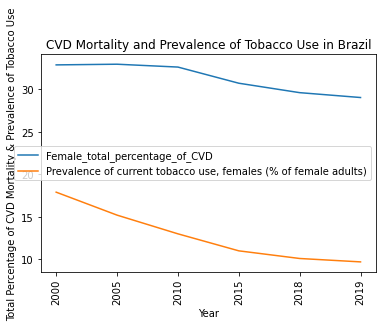

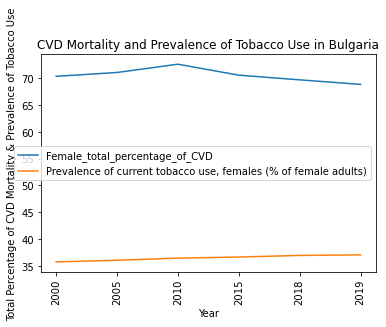

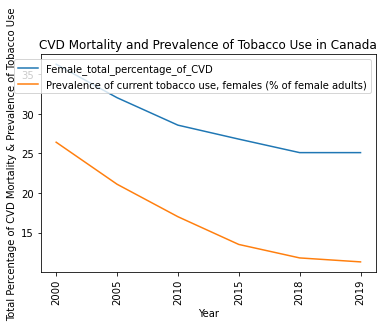

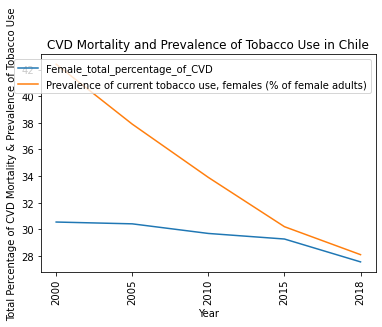

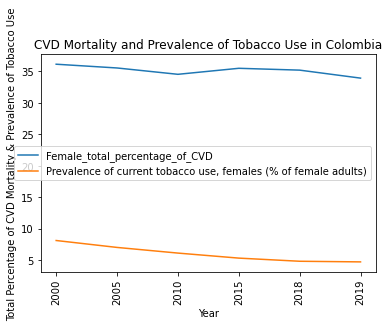

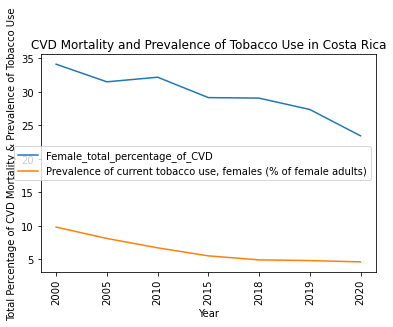

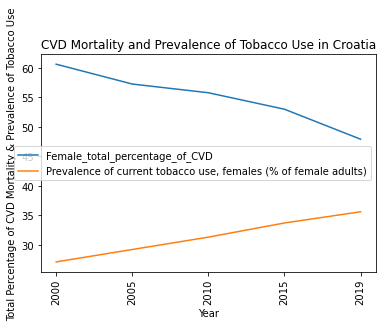

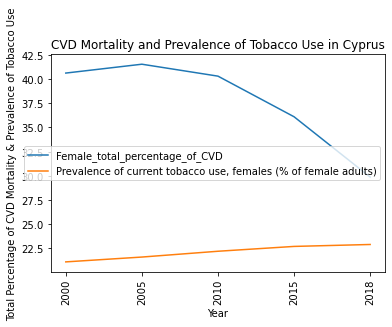

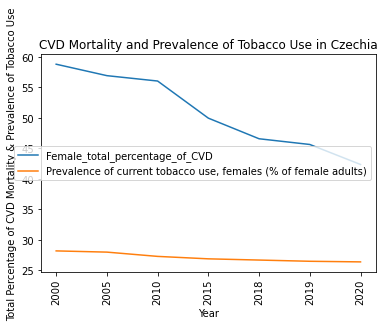

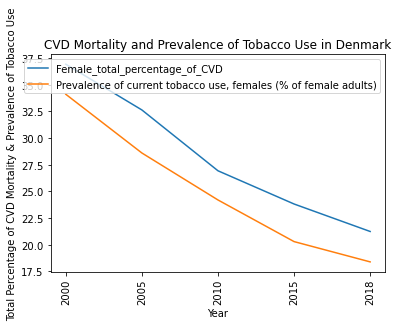

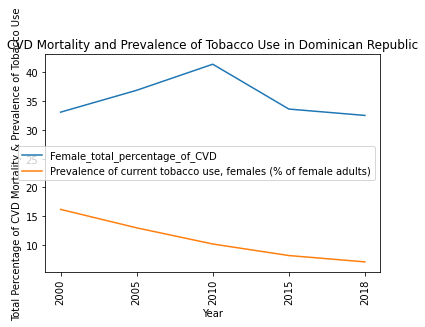

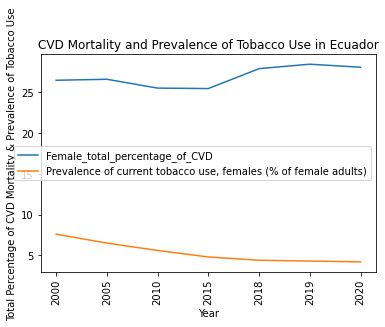

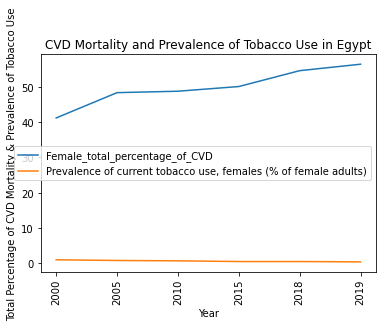

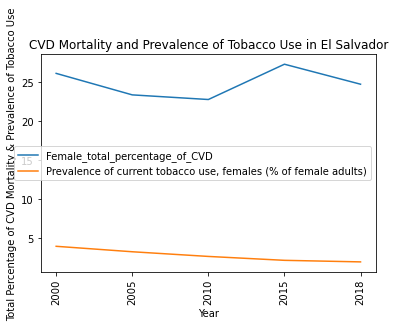

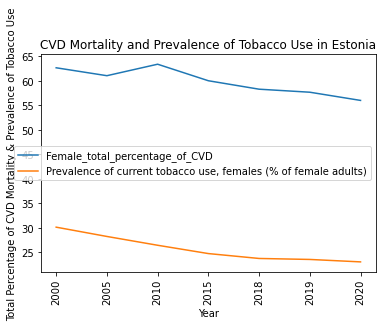

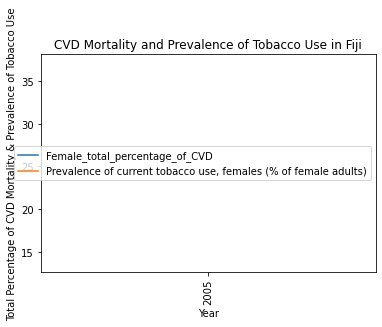

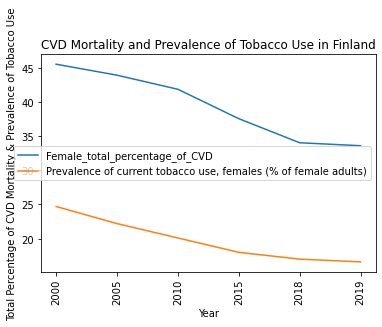

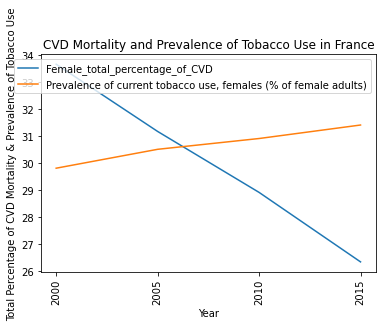

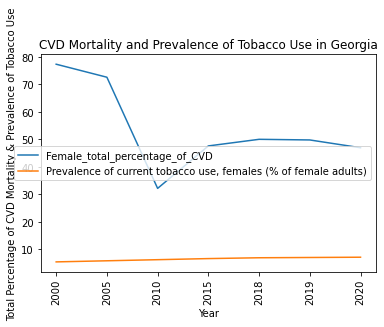

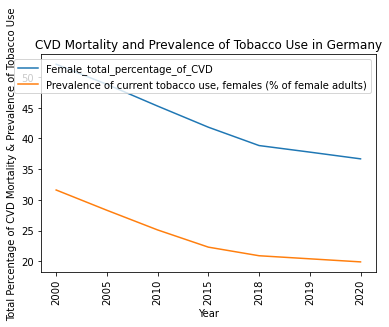

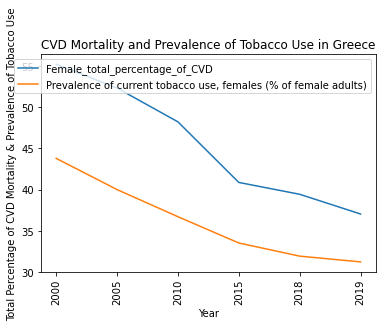

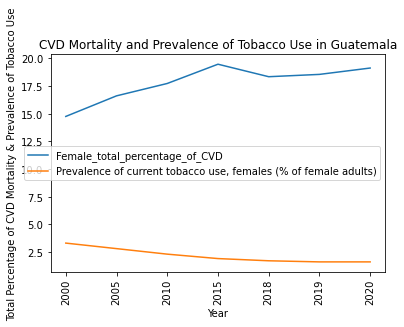

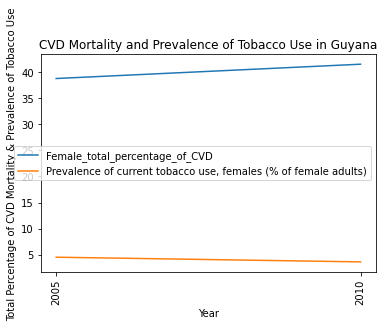

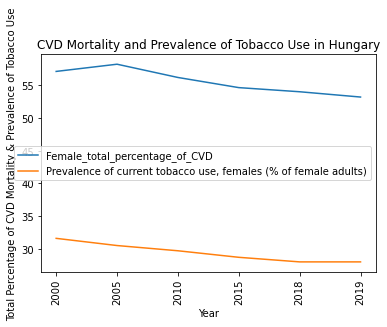

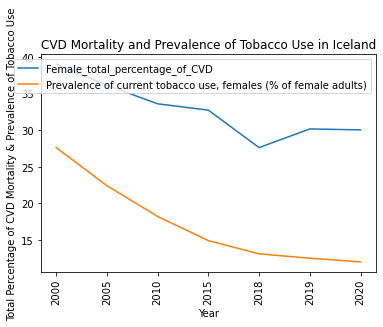

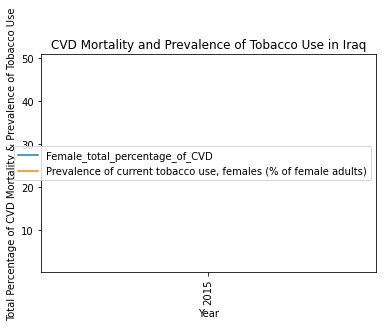

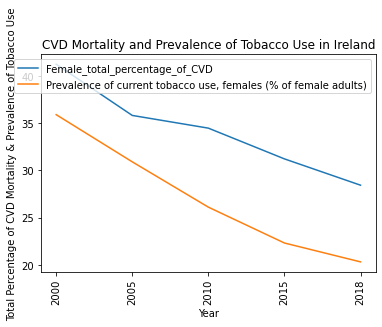

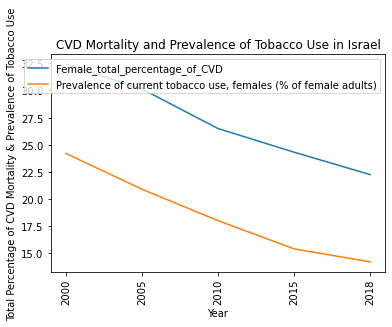

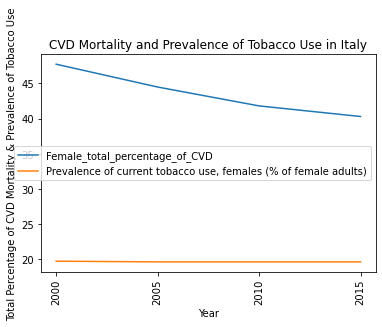

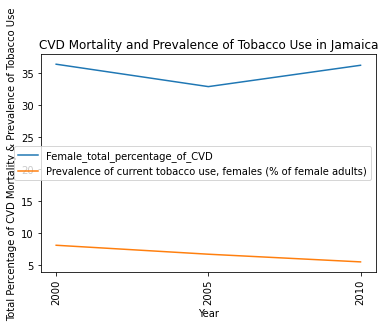

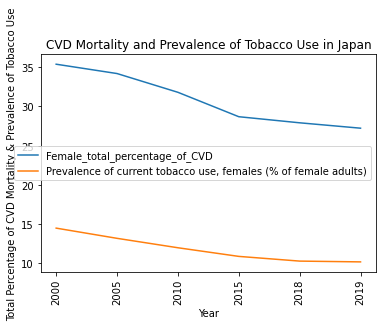

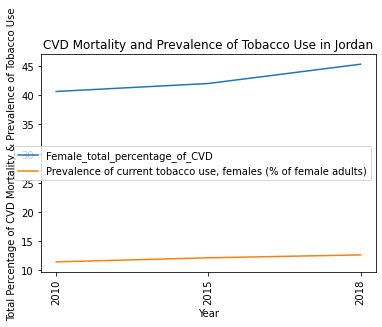

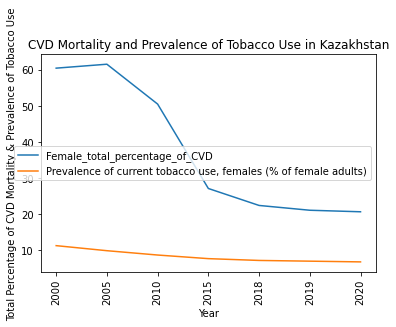

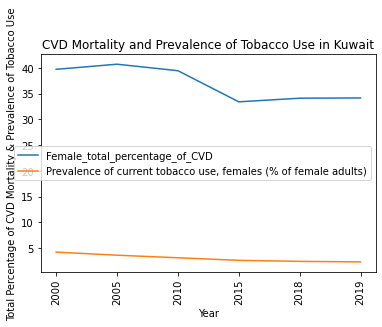

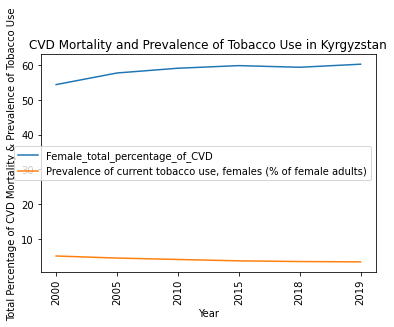

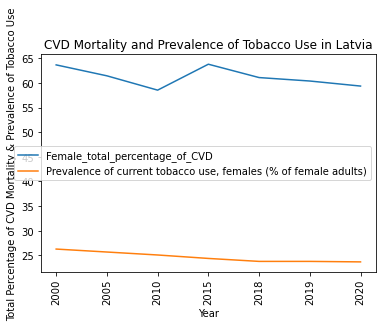

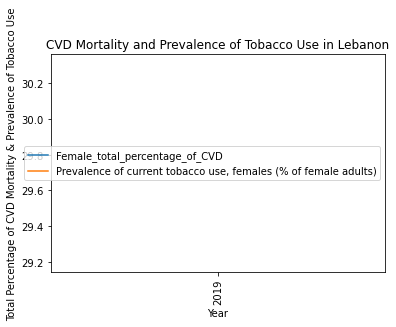

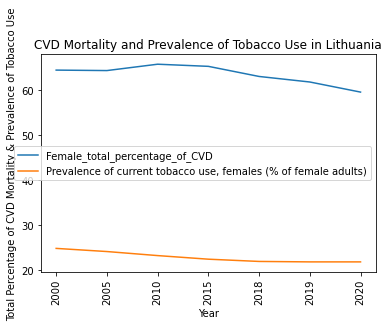

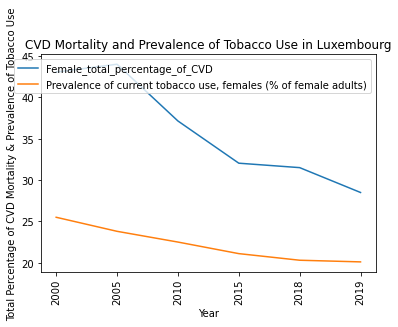

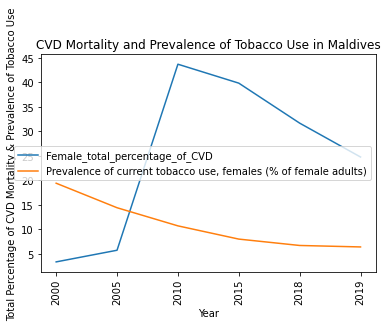

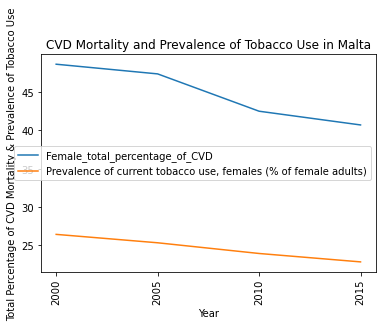

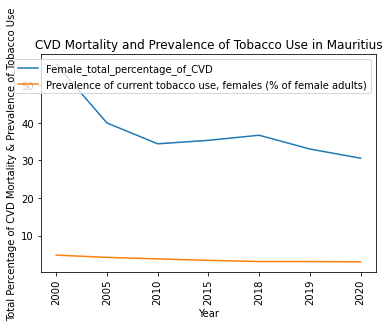

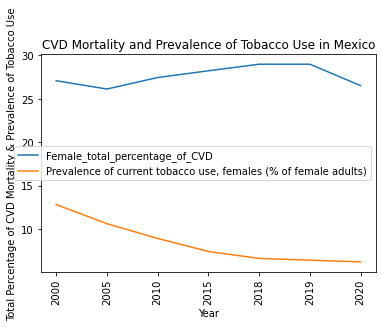

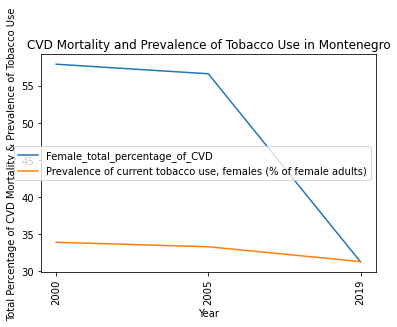

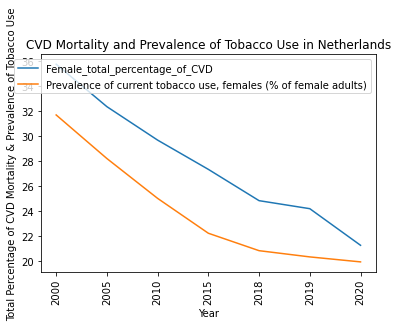

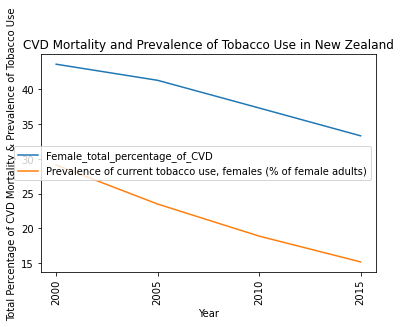

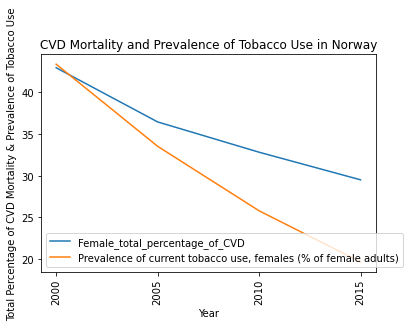

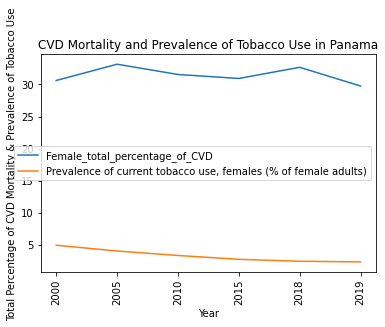

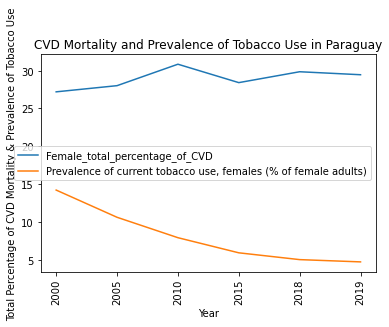

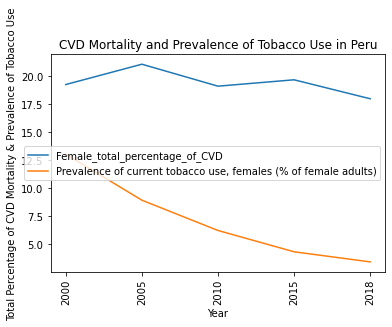

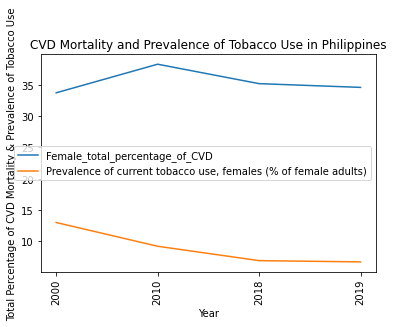

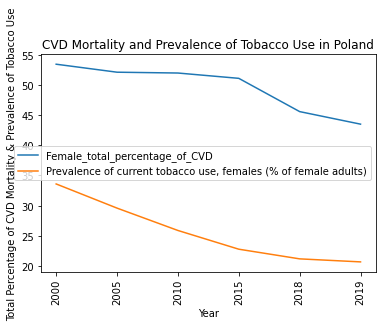

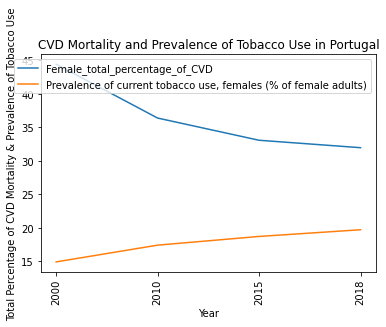

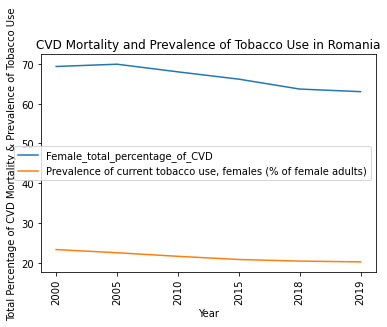

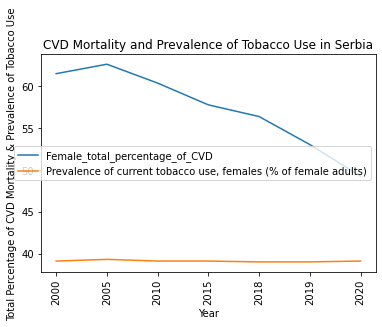

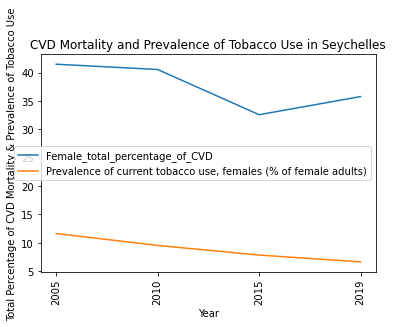

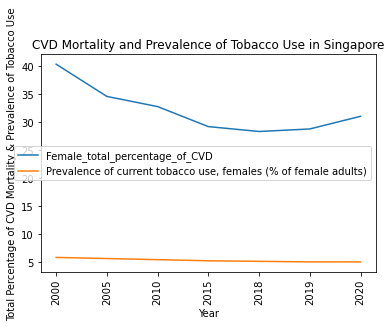

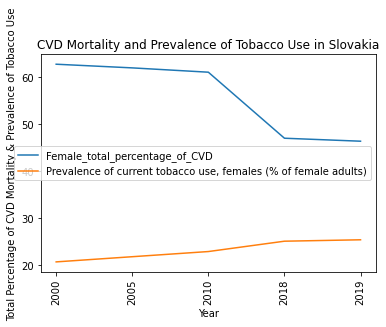

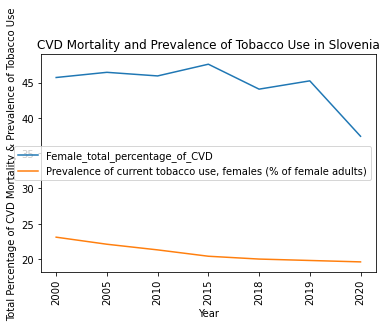

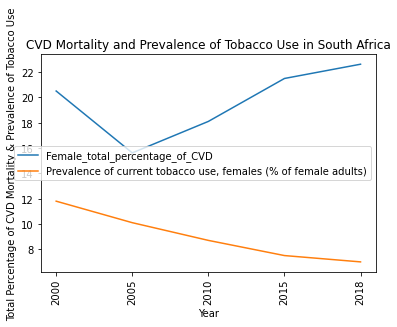

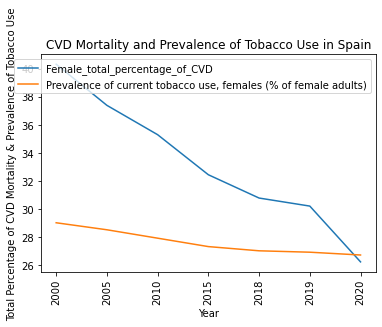

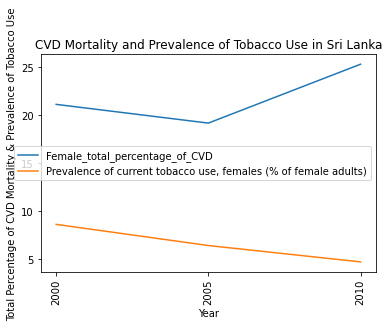

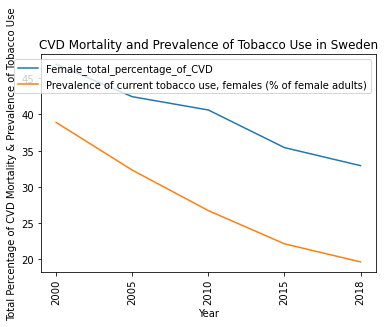

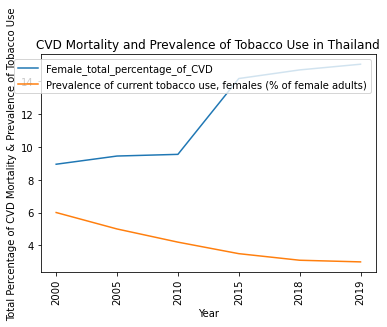

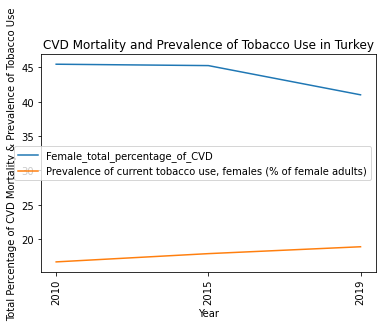

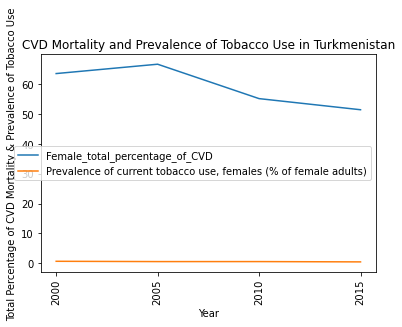

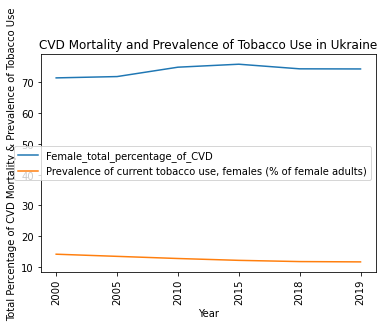

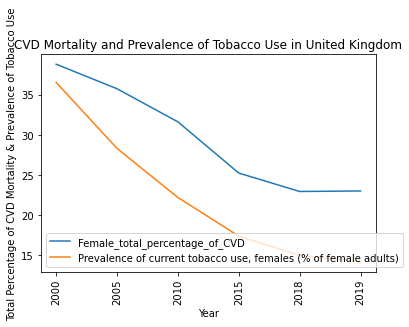

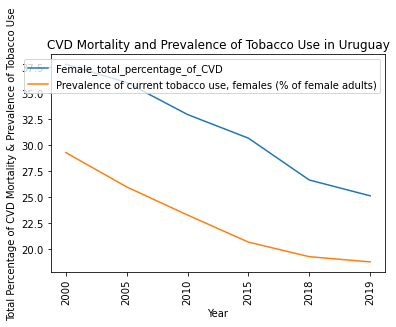

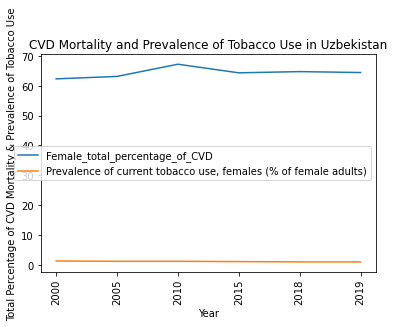

In [58]:
def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: str = None,
                      y_label: str = None,
                      save_path: Optional[Path] = None) -> pd.DataFrame:
    df['Year'] = df['Year'].astype(str)
    if select_country is not None:
        for country in select_country:
            country_df = df[df['Entity'] == country]
            if variable_1 is not None:
                plt.plot(country_df['Year'], country_df[variable_1[0]], label=variable_1[0])
            if variable_2 is not None:
                plt.plot(country_df['Year'], country_df[variable_2[0]], label=variable_2[0])
            if x_label is not None:
                plt.xlabel(x_label)
            if y_label is not None:
                plt.ylabel(y_label)
            plt.legend()
            plt.xticks(country_df['Year'], rotation=90)

            plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
            plt.show()

    if save_path is not None:
        df.to_excel(save_path)
    return df
if __name__ == '__main__':
    df= pd.read_excel(
        "/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/CVD_Tobacco_Parties_ratified.xlsx")
    select_country =df['Entity'].unique()
    variable_1 = ['Female_total_percentage_of_CVD']
    variable_2 = ['Prevalence of current tobacco use, females (% of female adults)']
    x_label = 'Year'
    y_label = 'Total Percentage of CVD Mortality & Prevalence of Tobacco Use'
    for country in select_country:
        df = plot_relationship(df, select_country=[country], variable_1=variable_1, variable_2=variable_2,
                           x_label=x_label, y_label=y_label)
